### "State of the art" cup recognition platform

- Interesting read: DL with small dataset - https://towardsdatascience.com/how-to-use-deep-learning-even-with-small-data-e7f34b673987

In [2]:
# Different useful libraries
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import glob
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
# ANN
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [16]:
# Helpers
from helpers import *
%run helpers.py

### Data loading

In [23]:
############################
###### Agumented Data ######
############################

aug_cups, aug_cup_size = import_images(path='henriks_images/augment_cup/')
aug_boxes, aug_box_size = import_images(path='henriks_images/augment_box/')
aug_books, aug_book_size = import_images(path='henriks_images/augment_book/')

aug_data, aug_labels = from_raw_to_CNN(aug_cups, aug_boxes, aug_books, aug_cup_size, aug_box_size, aug_book_size, resize=False)



(2016, 128, 128, 1) (2016,)


In [9]:
########################
###### Test data  ######
########################
real_cups, real_cup_size = import_images(path='test_samples/cups/')
real_boxes, real_box_size = import_images(path='test_samples/boxes/')
real_books, real_book_size = import_images(path='test_samples/books/')

test_data, test_labels = from_raw_to_CNN(real_cups, real_boxes, real_books, real_cup_size, real_box_size, real_book_size);

(26, 128, 128, 1) (26,)


In [17]:
############################
###### Training data  ######
############################

raw_cups, raw_cup_size = import_images(path='henriks_images/small_cup/')
raw_boxes, raw_box_size = import_images(path='henriks_images/small_box/')
raw_books, raw_book_size = import_images(path='henriks_images/small_book/')

raw_data, raw_labels = from_raw_to_CNN(raw_cups, raw_boxes, raw_books, raw_cup_size, raw_box_size, raw_book_size, resize=False);

(672, 128, 128, 1) (672,)


In [35]:
#########################
###### Cheat data  ######
#########################
# Combining raw data and test data
cheat_data = np.concatenate((raw_data, test_data))
cheat_labels = np.concatenate((raw_labels, test_labels))
raw_data.shape, test_data.shape, cheat_data.shape, 

((672, 128, 128, 1), (26, 128, 128, 1), (698, 128, 128, 1))

### CNN training time baby!

**CNN model 1 - using no dense hidden layers**
- Working on raw data
- 57.7% accuracy

In [18]:
input_shape = (128, 128, 1)

cnn_model_1 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        #layers.Dropout(0.5),
        layers.Dense(3, activation="softmax"), #layers.Dense(2, activation="softmax"),
    ]
)

cnn_model_1.compile(
                loss=tf.keras.metrics.sparse_categorical_crossentropy, #loss="categorical_crossentropy", #loss=tf.keras.metrics.binary_crossentropy, 
                optimizer=keras.optimizers.Adam(),
                metrics=["accuracy"],
                )


batch_size = 128 # 16, 32, 64, 128
epochs = 50
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode="min", verbose=1, patience=10) # 50

cnn_history_1 = cnn_model_1.fit(raw_data, raw_labels,
            batch_size=batch_size, epochs=epochs, 
            validation_split=0.1, verbose=0,
            callbacks=[PrintDot(), early_stop] # early_stop
            )


.................................Epoch 00033: early stopping


,loss,accuracy,val_loss,val_accuracy,epoch
32,0.067872,0.990066,0.303289,0.897059,32


Test loss: 1.0681090354919434
Test accuracy: 0.5769230723381042


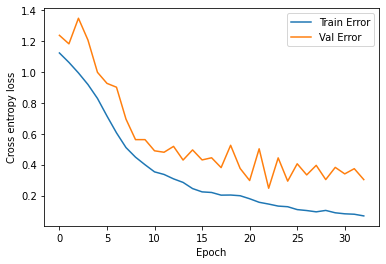

In [20]:
show_final_score(cnn_history_1)

score = cnn_model_1.evaluate(test_data, test_labels, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

**CNN Model 2**
- Same model as model 1, but working on augmented data
- 53% accuracy, and performs worse in every way

In [24]:
input_shape = (128, 128, 1)

cnn_model_2 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        #layers.Dropout(0.5),
        layers.Dense(3, activation="softmax"), #layers.Dense(2, activation="softmax"),
    ]
)

cnn_model_2.compile(
                loss=tf.keras.metrics.sparse_categorical_crossentropy, #loss="categorical_crossentropy", #loss=tf.keras.metrics.binary_crossentropy, 
                optimizer=keras.optimizers.Adam(),
                metrics=["accuracy"],
                )


batch_size = 128 # 16, 32, 64, 128
epochs = 50
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode="min", verbose=1, patience=10) # 50

cnn_history_2 = cnn_model_2.fit(raw_data, raw_labels,
            batch_size=batch_size, epochs=epochs, 
            validation_split=0.1, verbose=0,
            callbacks=[PrintDot(), early_stop] # early_stop
            )


....................Epoch 00020: early stopping


,loss,accuracy,val_loss,val_accuracy,epoch
19,0.212363,0.938742,0.473527,0.823529,19


Test loss: 0.8618704676628113
Test accuracy: 0.5384615659713745


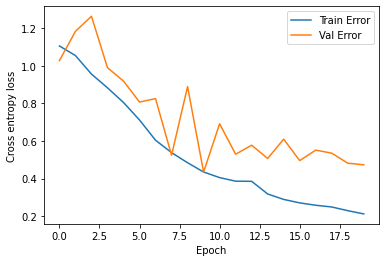

In [26]:
show_final_score(cnn_history_2)

score = cnn_model_2.evaluate(test_data, test_labels, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

**CNN Model 3**
- Testing out other forms of CNN
- Multiclass, single label classification https://towardsdatascience.com/the-complete-guide-to-neural-networks-multinomial-classification-4fe88bde7839
- CATS and DOGS https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-to-classify-photos-of-dogs-and-cats/


In [54]:
input_shape = (128, 128, 1)

cnn_model_3 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu", kernel_initializer='he_uniform', padding='same'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(16, activation="relu", kernel_initializer='he_uniform'),
        layers.Dense(3, activation="softmax"), #layers.Dense(2, activation="softmax"),
    ]
)

#cnn_model_3.compile(
#                #loss=tf.keras.metrics.sparse_categorical_crossentropy,
#                #loss=tf.keras.metrics.categorical_crossentropy, # Only difference to sparse is the format of labels.
#                #loss=tf.keras.metrics.binary_crossentropy, 
#                optimizer=keras.optimizers.Adam(),
#                metrics=["accuracy"],
#                )

#######################
## Cosine similarity ##
#######################

cnn_model_3.compile(optimizer=keras.optimizers.Adam(),
                    loss=tf.keras.losses.cosine_similarity, 
                    metrics=[tf.keras.metrics.CosineSimilarity(axis=1), "accuracy"])

batch_size = 32 # 16, 32, 64, 128
epochs = 50
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode="min", verbose=1, patience=10) # 50

cnn_history_3 = cnn_model_3.fit(raw_data, raw_labels,
            batch_size=batch_size, epochs=epochs, 
            validation_split=0.1, verbose=0,
            callbacks=[PrintDot()]#, early_stop] # early_stop
            )


..................................................

,loss,cosine_similarity,accuracy,val_loss,val_cosine_similarity,val_accuracy,epoch
49,-0.672185,0.672185,0.248344,-1.0,1.0,1.0,49


Test loss: -0.7692306041717529
Test accuracy: 0.7692306041717529


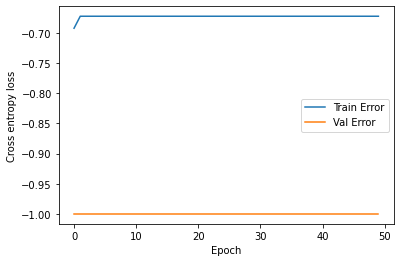

In [55]:
show_final_score(cnn_history_3)

score = cnn_model_3.evaluate(test_data, test_labels, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

**Interesting** 
- Adding a large dense layer => Much better fit on training data, but sucks at test data (50%)
- Adding the cheat data to the training data - gets a 30% despite a 80% validation accuracy. I guess it just ignores the cheat data, as its so few datapoints.